In [60]:
# https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17

!pip install tensorflow-gpu
!pip install nltk
!pip install keras
!pip install pydot
!pip install wordcloud
!pip install chart-studio
!pip install git+https://github.com/keras-team/keras-tuner

  Cloning https://github.com/keras-team/keras-tuner to /tmp/pip-req-build-_nz3xtnb
  Created wheel for keras-tuner: filename=keras_tuner-1.0.3-py3-none-any.whl size=93797 sha256=a52fb84e4be6e83b085edd9d054af61064f9ab3ca48ff4e10668addebbb2dd7b
  Stored in directory: /tmp/pip-ephem-wheel-cache-4io56t97/wheels/b0/f2/9d/8ebcfadb92ce3c9fc1536aec899918eafb7d984cf4e89c59b5
Successfully built keras-tuner


In [104]:
import numpy as np
import nltk
#import joblib
import re
import pydot
from wordcloud import WordCloud, ImageColorGenerator
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from kerastuner.tuners import RandomSearch, BayesianOptimization
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import chart_studio.plotly as py
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

#import numpy as np 
#import pandas as pd
#import matplotlib.pyplot as plt
#import seaborn as sns
#from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
#from keras.models import Sequential
#from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
#from sklearn.model_selection import train_test_split
#from keras.utils.np_utils import to_categorical
#from keras.callbacks import EarlyStopping
#from keras.layers import Dropout
#import re
#from nltk.corpus import stopwords
#from nltk import word_tokenize
#STOPWORDS = set(stopwords.words('english'))
#from bs4 import BeautifulSoup
#import plotly.graph_objs as go
#import plotly.plotly as py
#import cufflinks
#from IPython.core.interactiveshell import InteractiveShell
#import plotly.figure_factory as ff
#InteractiveShell.ast_node_interactivity = 'all'
#from plotly.offline import iplot
#cufflinks.go_offline()
#cufflinks.set_config_file(world_readable=True, theme='pearl')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [105]:
RANDOM_SEED=42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [106]:
df = pd.read_csv('coded_sub_section.csv',header=0)


In [107]:
df.head()

,Textfile,Determination_Year,Sub_Header,Sub_Section,Cond_Category,EScore
0,/home/admin/dockers/masters/data/pdfminer/search/MP08_0256-Mod-2.txt,2012.0,Pollution of Waters,Except as may be expressly provided by a OEH Environment Protection Licence the Proponent shall comply with section 120 of the Protection of the Environment Operations Act 1997 during the carrying out of the Project.,1,0.8550
1,/home/admin/dockers/masters/data/pdfminer/search/MP08_0102-Mod-1.txt,2012.0,Creek Diversions for the Underground Project,The Proponent shall carry out the proposed diversions of Bettys Creek and Main Creek in the underground project area to the satisfaction of the Director-General.,1,0.4275
2,/home/admin/dockers/masters/data/pdfminer/search/MP08_0102-Mod-1.txt,2012.0,Creek Diversions for the Underground Project,Within 6 months of completing the construction of the diversions the Proponent shall submit an as-executed report certified by a practising engineer to the Director-General and NOW.,1,0.6650
3,/home/admin/dockers/masters/data/pdfminer/search/MP07_0087-Mod-2.txt,2012.0,Discharge,Except as may be expressly provided for by an EPL or in accordance with section 120 of the Protection of the Environment Operations Act 1997 the Proponent shall not discharge any mine water from the site.,1,0.8550
4,/home/admin/dockers/masters/data/pdfminer/search/MP07_0087-Mod-2.txt,2012.0,Discharge,However water may be transferred between the site and the adjoining Donaldson Coal Mine and/or Abel Coal Mine in accordance with any approved Water Management Plan (see below).,1,0.5400


In [108]:
df.shape

(1033, 6)

In [109]:
df.Cond_Category.value_counts()

3    401
4    263
1    197
2    172
Name: Cond_Category, dtype: int64

In [110]:
df.Determination_Year.value_counts()

2015.0    144
2019.0    131
2016.0    125
2012.0    114
2014.0     99
2017.0     94
2018.0     91
2020.0     88
2013.0     54
2021.0     20
Name: Determination_Year, dtype: int64

In [111]:
df = df.drop(['Textfile','Sub_Header','Cond_Category','Determination_Year'],axis=1)

In [112]:
df['Stars'] = 0
df.head()

,Sub_Section,EScore,Stars
0,Except as may be expressly provided by a OEH Environment Protection Licence the Proponent shall comply with section 120 of the Protection of the Environment Operations Act 1997 during the carrying out of the Project.,0.8550,0
1,The Proponent shall carry out the proposed diversions of Bettys Creek and Main Creek in the underground project area to the satisfaction of the Director-General.,0.4275,0
2,Within 6 months of completing the construction of the diversions the Proponent shall submit an as-executed report certified by a practising engineer to the Director-General and NOW.,0.6650,0
3,Except as may be expressly provided for by an EPL or in accordance with section 120 of the Protection of the Environment Operations Act 1997 the Proponent shall not discharge any mine water from the site.,0.8550,0
4,However water may be transferred between the site and the adjoining Donaldson Coal Mine and/or Abel Coal Mine in accordance with any approved Water Management Plan (see below).,0.5400,0


In [113]:
for i in range(len(df)):
    if df.iloc[i,1] < .2:
        df.iloc[i,2] = 1
    elif df.iloc[i,1] < .4:
        df.iloc[i,2] = 2
    elif df.iloc[i,1] < .6:
        df.iloc[i,2] = 3
    elif df.iloc[i,1] < .8:
        df.iloc[i,2] = 4
    elif df.iloc[i,1] > .8:
        df.iloc[i,2] = 5  
        
df = df.drop(['EScore'],axis=1)

In [114]:
print(STOPWORDS)

{'mightn', 'with', 'you', 'just', "needn't", 'all', 'into', "won't", 'hers', 'they', 'having', 's', 'through', "you've", 'the', "wouldn't", 'too', 'under', 'and', 'itself', "it's", 'not', 'yourself', 'most', 'only', 've', 'd', 'more', 'such', 'm', 'again', 'which', 'didn', "you'll", "should've", 'should', "didn't", "you'd", 'him', 'each', "shan't", 'are', 'so', 'while', 'here', 'as', 'nor', 'yourselves', 'couldn', 'wasn', "you're", 'few', 'her', 'further', 'there', 't', "that'll", 'in', 'when', 'now', 'them', 'this', "mustn't", 'our', 'your', 'any', 'of', 'over', 'because', 'ourselves', 'it', 'against', 'be', 'to', 'before', 'between', "don't", 'weren', 'above', 'been', 'where', 'his', 'll', 'theirs', "doesn't", 'being', 'she', 'do', 'needn', "aren't", 'he', 're', 'about', 'did', 'same', 'who', 'y', 'my', "wasn't", 'can', 'was', 'own', "isn't", "weren't", 'haven', 'o', 'shan', 'on', "haven't", 'other', 'mustn', 'if', 'for', 'some', 'very', 'from', 'at', 'during', 'am', 'aren', 'has', '

# Text Processing 

- Convert all text to lower case.
- Replace REPLACE_BY_SPACE_RE symbols by space in text.
- Remove symbols that are in BAD_SYMBOLS_RE from text.
- Remove stop words.
- Remove digits in text.
- Remove single letters


In [115]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
SINGLE_LETTERS_RE = re.compile('\s+[a-zA-Z]\s+')
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.remove('should')
#STOPWORDS.add('applicant')
#STOPWORDS.add('proponent')
STOPWORDS.add('groundwater')
STOPWORDS.add('water')
STOPWORDS.add('environment')
STOPWORDS.add('act')

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
#    text = SINGLE_LETTERS_RE.sub('', text) # remove single letters
#    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text
    return text

df['Sub_Section'] = df['Sub_Section'].apply(clean_text)
df['Sub_Section'] = df['Sub_Section'].str.replace('\d+', '')

In [116]:
print(df['Sub_Section'][600])

plan must consistent requirements managing urban stormwater soils construction manual landcom  latest version ii identify activities could cause soil erosion generate sediment iii describe measures minimise soil erosion potential transport sediment downstream waters iv describe location function capacity erosion sediment control structures v describe measures would implemented monitor maintain structures time


In [117]:
df['Sub_Section'].describe()

count                                                                                                         1033
unique                                                                                                         449
top       compensatory supply measures must provide alternative longterm supply equivalent loss attributed project
freq                                                                                                            45
Name: Sub_Section, dtype: object

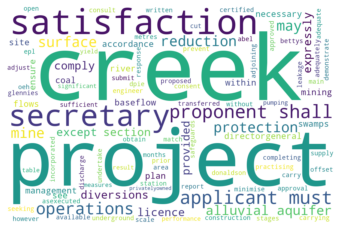

In [118]:
wordcloud = WordCloud(max_words=100, stopwords=STOPWORDS, background_color="white",width=1200,height=800).generate(str(df['Sub_Section']))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear', )
plt.axis("off")
plt.show()

# Save the image in the img folder:
wordcloud.to_file("wordcloud.png")

# Tokenising

- Vectorize text into either a sequence of integers or into a vector.
- Limit the data set to the top 125,0000 words.
- Set the max number of words for each sub_section at 500.
- Truncate and pad the subsections with zeros


In [119]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 3000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 500
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Sub_Section'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = tokenizer.texts_to_sequences(df['Sub_Section'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)


Y = pd.get_dummies(df['Stars']).values
print('Shape of label tensor:', Y.shape)

Found 1010 unique tokens.
Shape of data tensor: (1033, 500)
Shape of label tensor: (1033, 5)


In [120]:
print((df['Stars']).values)

[5 3 4 ... 3 3 2]


In [121]:
df['Stars'].describe()

count    1033.000000
mean        3.066796
std         1.376150
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: Stars, dtype: float64

In [141]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(929, 500) (929, 5)
(104, 500) (104, 5)


In [142]:
#One-hot-encode --> https://stackoverflow.com/questions/61550026/valueerror-shapes-none-1-and-none-3-are-incompatible#61550151

# Y_train = to_categorical(Y_train, 5)
# Y_test = to_categorical(Y_test, 5)

# Tune the Hyperparameters

## Optimise the Model

In [143]:
def tune_optimizer_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Dense(units=18, activation="relu", input_shape=[X_train.shape[1]]))

    model.add(keras.layers.Dense(1, activation='softmax'))   #sigmoid

    optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])

    model.compile(
        optimizer=optimizer,
        loss = 'categorical_crossentropy',    # binary_crossentropy
        metrics = ['accuracy'])
    return model

In [144]:
MAX_TRIALS = 20
EXECUTIONS_PER_TRIAL = 5

tuner = RandomSearch(
    tune_optimizer_model,
    objective='val_accuracy',
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTIONS_PER_TRIAL,
    directory='test_dir', 
    project_name='tune_optimizer',
    seed=RANDOM_SEED
)

tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project test_dir/tune_optimizer/oracle.json
Search space summary
Default search space size: 1
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd', 'rmsprop'], 'ordered': False}


In [145]:
TRAIN_EPOCHS = 20

tuner.search(x=X_train,
             y=Y_train,
             epochs=TRAIN_EPOCHS,
             validation_data=(X_test, Y_test))


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
optimizer         |rmsprop           |?                 

Epoch 1/20


ValueError: in user code:

    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:755 train_step
        loss = self.compiled_loss(
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:1537 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:4833 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /opt/conda/lib/python3.8/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 5) and (None, 1) are incompatible


In [ ]:
tuner.results_summary()

In [ ]:
tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

In [ ]:
best_model = tuner.get_best_models()[0]

In [ ]:
best_model.summary()

In [22]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 100)          300000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 500, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 5)                 505       
Total params: 380,905
Trainable params: 380,905
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
# from keras.utils import plot_model
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [24]:
epochs = 20
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/20
14/14 [==============================] - 11s 644ms/step - loss: 1.5812 - accuracy: 0.2684 - val_loss: 1.3604 - val_accuracy: 0.4194
Epoch 2/20
14/14 [==============================] - 9s 603ms/step - loss: 1.4407 - accuracy: 0.4367 - val_loss: 1.1822 - val_accuracy: 0.6989
Epoch 3/20
14/14 [==============================] - 9s 617ms/step - loss: 1.2299 - accuracy: 0.6345 - val_loss: 0.9105 - val_accuracy: 0.7204
Epoch 4/20
14/14 [==============================] - 9s 611ms/step - loss: 0.9170 - accuracy: 0.6744 - val_loss: 0.7233 - val_accuracy: 0.8280
Epoch 5/20
14/14 [==============================] - 8s 604ms/step - loss: 0.6447 - accuracy: 0.8119 - val_loss: 0.5729 - val_accuracy: 0.8602
Epoch 6/20
14/14 [==============================] - 9s 610ms/step - loss: 0.4591 - accuracy: 0.8644 - val_loss: 0.5035 - val_accuracy: 0.8495
Epoch 7/20
14/14 [==============================] - 8s 608ms/step - loss: 0.3527 - accuracy: 0.9203 - val_loss: 0.4515 - val_accuracy: 0.8602
Epoch

In [25]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

4/4 [==============================] - 0s 69ms/step - loss: 0.2174 - accuracy: 0.9423
Test set
  Loss: 0.217
  Accuracy: 0.942


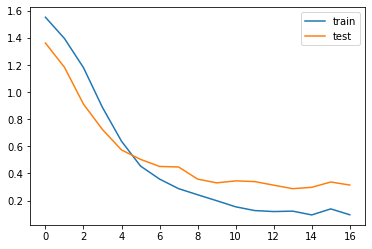

In [26]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [27]:
print(history.history)

{'loss': [1.5504106283187866, 1.3940457105636597, 1.1793187856674194, 0.8856523036956787, 0.6372648477554321, 0.45405641198158264, 0.35834985971450806, 0.2878487706184387, 0.24300679564476013, 0.19913506507873535, 0.15412604808807373, 0.12643253803253174, 0.11916480213403702, 0.1222517117857933, 0.094380222260952, 0.13872963190078735, 0.0955219566822052], 'accuracy': [0.2954545319080353, 0.5, 0.6555023789405823, 0.6997607946395874, 0.8110047578811646, 0.8612440228462219, 0.9090909361839294, 0.9270334839820862, 0.9437798857688904, 0.9473684430122375, 0.9533492922782898, 0.9677033424377441, 0.9712918400764465, 0.9677033424377441, 0.9784688949584961, 0.9581339955329895, 0.9796651005744934], 'val_loss': [1.3604146242141724, 1.1821706295013428, 0.9104975461959839, 0.7233192920684814, 0.5729478001594543, 0.5035080313682556, 0.45145103335380554, 0.4474032521247864, 0.3582676649093628, 0.3305717408657074, 0.34500283002853394, 0.33988988399505615, 0.3134770691394806, 0.28752848505973816, 0.2976

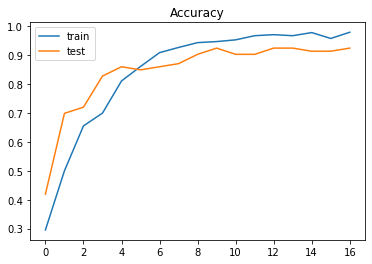

In [28]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [36]:
new_sub_header = ['The Applicant shall comply with the performance measures in Table 11 to the satisfaction of the \
Secretary irrespective of any other measures being implemented by the Applicant to provide \
compensatory water supply in accordance with condition 23 above.\
 ']

df_new = pd.DataFrame(new_sub_header)
df_new[0] = df_new[0].apply(clean_text)
df_new[0] = df_new[0].str.replace('\d+', '')

pd.set_option('display.max_colwidth', None)
print(str(df_new[0]))

seq = tokenizer.texts_to_sequences(df_new[0].values)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['1', '2', '3', '4', '5']
print(pred, labels[np.argmax(pred)])
#print(pred,[np.argmax(pred)])                 

0    applicant shall comply performance measures table  satisfaction secretary irrespective measures implemented applicant provide compensatory water supply accordance condition 
Name: 0, dtype: object
[[3.3206359e-04 9.9949491e-01 9.5771487e-05 1.8785933e-05 5.8429985e-05]] 2


In [35]:
# save the model to disk
model.save('enforceability_model.h5')


In [28]:
from plotly.offline import plot
from chart_studio.plotly import plot, iplot
from plotly.subplots import make_subplots

fig = go.Figure(go.Indicator(
    domain = {'x': [0, 1], 'y': [0, 1]},
    value = 5,
    mode = "gauge+number+delta",
    title = {'text': "Enforceability Score"},
    delta = {'reference': 3},
    gauge = {'axis': {'range': [None, 5]},
             'steps' : [
                 {'range': [0, 2], 'color': "lightgray"},
                 {'range': [2, 4], 'color': "gray"},
                 {'range': [4, 5], 'color': "green"}],
             'threshold' : {'line': {'color': "red", 'width': 4}, 'thickness': 0.75, 'value': 4}}))

plotly.offline.iplot(fig)
#fig.show()

NameError: name 'plotly' is not defined

In [29]:
import chart_studio.plotly as py
from plotly.offline import plot, iplot
trace0 = go.Scatter(
    x=[1, 2, 3, 4],
    y=[10, 15, 13, 17]
)
trace1 = go.Scatter(
    x=[1, 2, 3, 4],
    y=[16, 5, 11, 9]
)
data = [trace0, trace1]

py.iplot(data, filename = 'basic-line')

PlotlyRequestError: Authentication credentials were not provided.

In [ ]:
import chart_studio.plotly as py
from plotly.offline import plot
help(py.plot)